# Final Project Demo Submission


In [1]:
import os
import numpy as np
import pandas as pd
import re
import sys
import json
from sklearn.metrics import DistanceMetric
from tqdm import tqdm

# GIS imports
import geopandas as gpd
from shapely.geometry import LineString

In [8]:
# constants
interval = 4
file_path = "data/train.csv"
sampling_interval = 15

## Data preparation and cleaning

We filter out any coordinates strings that have less than `2 * interval` coordinates. This is to ensure the trip is long enough to get an accurate measurement.


In [7]:
def load_data(path: str, nrows=10000):
    df = pd.read_csv(path, nrows=nrows)
    return df


def preprocess_data(df: pd.DataFrame):
    def prepare_linestrings(x):
        return LineString(x) #, srid=4326)

    df["traj"] = json.loads("[" + df.POLYLINE.str.cat(sep=",") + "]")
    df = df[df.traj.str.len() > interval * 2].copy()
    df["lines"] = gpd.GeoSeries(df.traj.apply(prepare_linestrings))
    gdf = gpd.GeoDataFrame(df, geometry="lines")
    return gdf


df = load_data(file_path)
gdf = preprocess_data(df)
gdf

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,traj,lines
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...","[[-8.618643, 41.141412], [-8.618499, 41.141376...","LINESTRING (-8.61864 41.14141, -8.61850 41.141..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...","[[-8.639847, 41.159826], [-8.640351, 41.159871...","LINESTRING (-8.63985 41.15983, -8.64035 41.159..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...","[[-8.612964, 41.140359], [-8.613378, 41.14035]...","LINESTRING (-8.61296 41.14036, -8.61338 41.140..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...","[[-8.574678, 41.151951], [-8.574705, 41.151942...","LINESTRING (-8.57468 41.15195, -8.57470 41.151..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...","[[-8.645994, 41.18049], [-8.645949, 41.180517]...","LINESTRING (-8.64599 41.18049, -8.64595 41.180..."
...,...,...,...,...,...,...,...,...,...,...,...
9995,1372839081620000157,A,2002.0,NaN,20000157,1372839081,A,False,"[[-8.66808,41.154651],[-8.668089,41.154651],[-...","[[-8.66808, 41.154651], [-8.668089, 41.154651]...","LINESTRING (-8.66808 41.15465, -8.66809 41.154..."
9996,1372839306620000084,A,2001.0,NaN,20000084,1372839306,A,False,"[[-8.583129,41.164731],[-8.583129,41.164785],[...","[[-8.583129, 41.164731], [-8.583129, 41.164785...","LINESTRING (-8.58313 41.16473, -8.58313 41.164..."
9997,1372837509620000467,C,NaN,NaN,20000467,1372837509,A,False,"[[-8.600103,41.18274],[-8.599806,41.182722],[-...","[[-8.600103, 41.18274], [-8.599806, 41.182722]...","LINESTRING (-8.60010 41.18274, -8.59981 41.182..."
9998,1372822350620000688,A,53492.0,NaN,20000688,1372822350,A,False,"[[-8.5878,41.174568],[-8.587782,41.174595],[-8...","[[-8.5878, 41.174568], [-8.587782, 41.174595],...","LINESTRING (-8.58780 41.17457, -8.58778 41.174..."


In [9]:
from sklearn.metrics import DistanceMetric

metric = DistanceMetric.get_metric("haversine")
dt = sampling_interval / 3600  # 15 second intervals over the course of 1 hour (3600 seconds)
R = 6371  # 6371 is the radius of the earth in kilometers


def fit_rational(x, y, w=1):
    ws = np.sqrt(w)
    (a, b), _, _, _ = np.linalg.lstsq(
        np.column_stack([x, -y]) * ws[:, None], x * y * ws, rcond=None
    )
    return a * x / (x + b), (a, b)


def dist_sequence(coords):
    n = len(coords)
    dist = R * metric.pairwise(np.radians(coords)).ravel()
    offsets = (np.arange(n)[:, None] - np.arange(n)).ravel()
    return pd.DataFrame(
        [offsets[offsets > 0] * dt * 60, dist[offsets > 0]],
        index=["time_offset", "distance"],
    ).T


dist_ungrouped = pd.concat(gdf.traj.apply(dist_sequence).values).set_index("time_offset")
dists = np.sqrt((dist_ungrouped**2).groupby("time_offset").mean() / 2)
thresh = -2
dists["curve"], coeffs = fit_rational(
    dists.index.values,
    dists.distance.values,
    ((1 + np.arange(len(dists))) / (1 + len(dists))) ** -3,
)


def likelihood(coords, ab):
    n = len(coords)
    a, b = coeffs
    dist = R * metric.pairwise(np.radians(coords))
    time = dt * 60 * np.abs(np.arange(n)[:, None] - np.arange(n))
    sigma = a * time / (time + b) + np.eye(n)
    lr = -0.5 * (dist**2 / sigma**2).sum(axis=1)
    return lr


def norm_lr(lr):
    return (lr - lr.max()) / len(lr)


bad_routes = gdf.traj.apply(
    lambda t: (norm_lr(likelihood(t, coeffs)) < thresh).any()
).values

In [10]:
df = gdf[~bad_routes]
df

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,traj,lines
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...","[[-8.618643, 41.141412], [-8.618499, 41.141376...","LINESTRING (-8.61864 41.14141, -8.61850 41.141..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...","[[-8.639847, 41.159826], [-8.640351, 41.159871...","LINESTRING (-8.63985 41.15983, -8.64035 41.159..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...","[[-8.574678, 41.151951], [-8.574705, 41.151942...","LINESTRING (-8.57468 41.15195, -8.57470 41.151..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...","[[-8.645994, 41.18049], [-8.645949, 41.180517]...","LINESTRING (-8.64599 41.18049, -8.64595 41.180..."
5,1372636965620000231,C,NaN,NaN,20000231,1372636965,A,False,"[[-8.615502,41.140674],[-8.614854,41.140926],[...","[[-8.615502, 41.140674], [-8.614854, 41.140926...","LINESTRING (-8.61550 41.14067, -8.61485 41.140..."
...,...,...,...,...,...,...,...,...,...,...,...
9995,1372839081620000157,A,2002.0,NaN,20000157,1372839081,A,False,"[[-8.66808,41.154651],[-8.668089,41.154651],[-...","[[-8.66808, 41.154651], [-8.668089, 41.154651]...","LINESTRING (-8.66808 41.15465, -8.66809 41.154..."
9996,1372839306620000084,A,2001.0,NaN,20000084,1372839306,A,False,"[[-8.583129,41.164731],[-8.583129,41.164785],[...","[[-8.583129, 41.164731], [-8.583129, 41.164785...","LINESTRING (-8.58313 41.16473, -8.58313 41.164..."
9997,1372837509620000467,C,NaN,NaN,20000467,1372837509,A,False,"[[-8.600103,41.18274],[-8.599806,41.182722],[-...","[[-8.600103, 41.18274], [-8.599806, 41.182722]...","LINESTRING (-8.60010 41.18274, -8.59981 41.182..."
9998,1372822350620000688,A,53492.0,NaN,20000688,1372822350,A,False,"[[-8.5878,41.174568],[-8.587782,41.174595],[-8...","[[-8.5878, 41.174568], [-8.587782, 41.174595],...","LINESTRING (-8.58780 41.17457, -8.58778 41.174..."


In [137]:
n = 20
random_state = 21

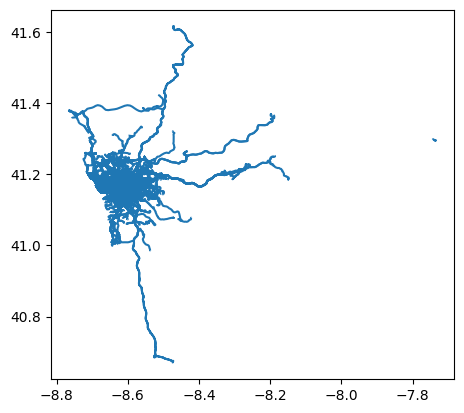

In [138]:
taxi_train_data = df.copy()
taxi_train_data["lines"].plot();

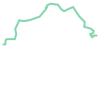

In [147]:
s = taxi_train_data.sample()["lines"].values[0]
s

Here, we grab the last 4 GPS coordinates from the `LineString`. This represents the end of a taxi trip, where a taxi is presumably parking to let a passenger out of their car. We recognize that this is not a perfect solution, as a taxi could be parking for other reasons, but we believe this is a good enough approximation for our purposes.

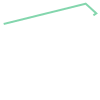

In [148]:
lat, lon = s.coords.xy
list(zip(lat, lon))[-4:]
vis = LineString(list(zip(lat, lon))[-4:])
vis

We calculate the distance by using the `LineString` object

In [150]:
s.distance(s.interpolate(0.5, normalized=True))

7163    8.495569e-16
dtype: float64

In [153]:
taxi_train_data["distances"] = taxi_train_data["lines"].apply(lambda x: x.distance(x.interpolate(0.5, normalized=True)))
taxi_train_data = taxi_train_data[taxi_train_data["distances"].notnull()]
taxi_train_data.head()

c:\Users\nicol\Anaconda3\envs\tcss565\Lib\site-packages\shapely\measurement.py:72: RuntimeWarning: invalid value encountered in distance
  return lib.distance(a, b, **kwargs)


,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,traj,lines,distances
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...","[[-8.618643, 41.141412], [-8.618499, 41.141376...","LINESTRING (-8.61864 41.14141, -8.61850 41.141...",1.390117e-15
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...","[[-8.639847, 41.159826], [-8.640351, 41.159871...","LINESTRING (-8.63985 41.15983, -8.64035 41.159...",2.135339e-15
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...","[[-8.574678, 41.151951], [-8.574705, 41.151942...","LINESTRING (-8.57468 41.15195, -8.57470 41.151...",1.331680e-15
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...","[[-8.645994, 41.18049], [-8.645949, 41.180517]...","LINESTRING (-8.64599 41.18049, -8.64595 41.180...",2.006503e-15
5,1372636965620000231,C,NaN,NaN,20000231,1372636965,A,False,"[[-8.615502,41.140674],[-8.614854,41.140926],[...","[[-8.615502, 41.140674], [-8.614854, 41.140926...","LINESTRING (-8.61550 41.14067, -8.61485 41.140...",2.209443e-15


We'll define the dataset by taking the last 4 timesteps of the data as an indication of "looking for parking," and then another non-overlapping sample from the same timeseries of 4 timesteps is used for an indication of "not looking for parking."

In [154]:
interval = 4
train_index = taxi_train_data.index

In [155]:
taxi_train_data.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,traj,lines,distances
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...","[[-8.618643, 41.141412], [-8.618499, 41.141376...","LINESTRING (-8.61864 41.14141, -8.61850 41.141...",1.390117e-15
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...","[[-8.639847, 41.159826], [-8.640351, 41.159871...","LINESTRING (-8.63985 41.15983, -8.64035 41.159...",2.135339e-15
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...","[[-8.574678, 41.151951], [-8.574705, 41.151942...","LINESTRING (-8.57468 41.15195, -8.57470 41.151...",1.331680e-15
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...","[[-8.645994, 41.18049], [-8.645949, 41.180517]...","LINESTRING (-8.64599 41.18049, -8.64595 41.180...",2.006503e-15
5,1372636965620000231,C,NaN,NaN,20000231,1372636965,A,False,"[[-8.615502,41.140674],[-8.614854,41.140926],[...","[[-8.615502, 41.140674], [-8.614854, 41.140926...","LINESTRING (-8.61550 41.14067, -8.61485 41.140...",2.209443e-15


In [156]:
from rich import inspect

s = taxi_train_data.sample()["traj"][-interval:].values[0]
parking_coords = s[-interval:]
parking_coords

[[-8.624574, 41.158125],
 [-8.624007, 41.158845],
 [-8.623548, 41.158098],
 [-8.623458, 41.15781]]

In [157]:
LineString(parking_coords).length

0.00209493924379884

In [159]:
def get_random_sample(x, interval=4):
    start_idx = np.random.randint(0, len(x) - 2 * interval)
    return x[start_idx : start_idx + interval]


normal_coords = get_random_sample(s)
normal_coords

[[-8.630784, 41.157018],
 [-8.629965, 41.157198],
 [-8.628615, 41.157099],
 [-8.627805, 41.157567]]

In [160]:
LineString(normal_coords).length

0.0031276527154178897

In [161]:
labels = ["normal", "parking"]

parking_coords = taxi_train_data["traj"].apply(lambda x: x[-interval:])
parking_coords.name = "parking_coords"
parking_coords

0       [[-8.630829, 41.154507], [-8.630829, 41.154516...
1       [[-8.668098, 41.168988], [-8.66664, 41.170005]...
3       [[-8.607996, 41.142879], [-8.607987, 41.142888...
4       [[-8.687502, 41.176755], [-8.687259, 41.177781...
5       [[-8.578719, 41.156271], [-8.578629, 41.157693...
                              ...                        
9995    [[-8.620623, 41.146074], [-8.620128, 41.145966...
9996    [[-8.638776, 41.164353], [-8.638776, 41.164344...
9997    [[-8.596863, 41.204925], [-8.596656, 41.204403...
9998    [[-8.670402, 41.238135], [-8.670033, 41.236884...
9999    [[-8.631909, 41.185728], [-8.63208, 41.186484]...
Name: parking_coords, Length: 9399, dtype: object

In [162]:
normal_coords = taxi_train_data["traj"].apply(get_random_sample)
normal_coords.name = "normal_coords"
normal_coords

0       [[-8.62911, 41.151213], [-8.629128, 41.15124],...
1       [[-8.646921, 41.160951], [-8.649999, 41.161491...
3       [[-8.604045, 41.145417], [-8.604657, 41.144256...
4       [[-8.656353, 41.177853], [-8.659647, 41.177277...
5       [[-8.592993, 41.140008], [-8.589384, 41.140674...
                              ...                        
9995    [[-8.644851, 41.148252], [-8.642826, 41.148009...
9996    [[-8.638767, 41.164488], [-8.638794, 41.164326...
9997    [[-8.605575, 41.191542], [-8.605611, 41.192838...
9998    [[-8.587242, 41.198949], [-8.586315, 41.198652...
9999    [[-8.619867, 41.170986], [-8.621685, 41.169798...
Name: normal_coords, Length: 9399, dtype: object

In [163]:
normal_labels = pd.Series([0] * len(normal_coords), name="label", index=normal_coords.index)
parking_labels = pd.Series([1] * len(parking_coords), name="label", index=parking_coords.index)

In [164]:
normal_distances = normal_coords.apply(lambda x: LineString(x).length)
normal_distances.name = "distance"
parking_distances = parking_coords.apply(lambda x: LineString(x).length)
parking_distances.name = "distance"

In [165]:
normal_data = pd.concat([normal_distances, normal_labels], axis=1)
normal_data.describe()

,distance,label
count,9399.000000,9399.0
mean,0.004002,0.0
std,0.003558,0.0
min,0.000000,0.0
25%,0.001693,0.0
50%,0.003253,0.0
75%,0.005172,0.0
max,0.052607,0.0


In [166]:
parking_data = pd.concat([parking_distances, parking_labels], axis=1)
parking_data.describe()

,distance,label
count,9399.000000,9399.0
mean,0.001747,1.0
std,0.002418,0.0
min,0.000000,1.0
25%,0.000176,1.0
50%,0.001092,1.0
75%,0.002578,1.0
max,0.054472,1.0


In [169]:
def build_data(normal_data, parking_data):
    data = pd.merge(normal_data, parking_data, how="outer")
    return data

train_data = build_data(normal_data, parking_data)
train_data

,distance,label
0,0.001252,0
1,0.009652,0
2,0.005499,0
3,0.008831,0
4,0.010130,0
...,...,...
18793,0.000533,1
18794,0.000536,1
18795,0.003316,1
18796,0.001675,1


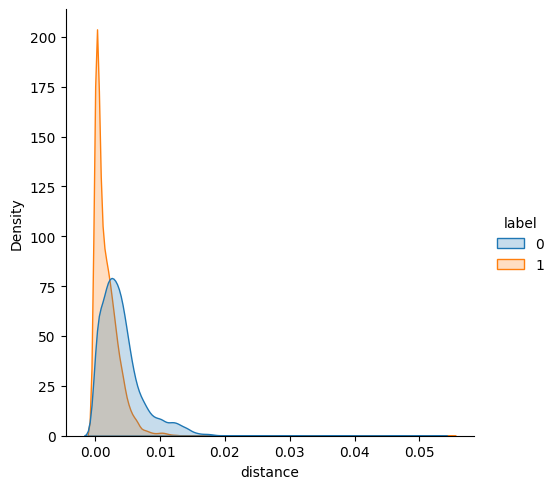

In [170]:
import seaborn as sns

sns.displot(train_data, x="distance", hue="label", kind="kde", fill=True);


We will now create our training and test splits.

In [171]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    train_data["distance"].values.reshape(-1, 1),
    train_data["label"].values,
    test_size=0.2,
    random_state=random_state,
    stratify=train_data["label"].values,
)
y_train.shape, y_test.shape

((15038,), (3760,))

Lets look at the distribution of the training data:

We can see from this density plot that the data is skewed towards the "not looking for parking" class. This is expected, as most of the time, people are not looking for parking. However, this is a problem for us, as we want to train a model that can accurately predict both classes.

# Experiments

Here we have two main experiments: experiment 1 investigates different machine learning models for the parking driver profile, while experiment 2 demonstrates the model's ability to predict parking behavior in a real-time setting using user collected data.

## Experiment 1: Model training and evaluation
Here we train 3 machine learning models and measure the performance of each model. We use the following models:
- Logistic Regression
- Support Vector Machine
- Random Forest
- XGBoost

For metrics, we use the following:

- Accuracy
- Precision
- Recall
- F1 Score
- ROC AUC

These metrics are commonly used in classification problems, and thus we will use them to evaluate our models. Each metric is presented for every split. Cross validation is performed on the training data, and the best model is selected based on the ROC_AUC of the model.


In [132]:
from sklearn.model_selection import GridSearchCV
split_names = ["train", "test"]
scoring = ["accuracy", "precision", "recall", "f1", "roc_auc"]


### `Logistic Regression`

In [172]:
from sklearn.linear_model import LogisticRegression

params = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "penalty": ["l1", "l2"],
    "solver": ["liblinear", "saga"],
    "max_iter": [1000, 2500, 5000],
}
logr = GridSearchCV(
    LogisticRegression(),
    params,
    cv=5,
    verbose=2,
    n_jobs=-1,
    refit="accuracy",
    scoring=scoring,
    return_train_score=True,
)
logr.fit(X_train, y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [1000, 2500, 5000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=2)

We'll start keeping track of all of the results for easy documentation later:

In [173]:
def collect_metrics(model_name: str, results: dict):
    result = [model_name]
    split_metric_names = ["model_name"]
    for split in split_names:
        for metric in scoring:
            split_metric_name = "_".join(["mean", split, metric])
            split_metric_names.append(split_metric_name)

    for split_metric_name in split_metric_names[1:]:
        # print(split_metric_name, logr_results[split_metric_name].mean())
        result.append(results[split_metric_name].mean())

    return pd.DataFrame([result], columns=split_metric_names).set_index("model_name")

logr_results = collect_metrics("LogisticRegression", logr.cv_results_)
logr_results

,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,mean_train_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
model_name,,,,,,,,,,
LogisticRegression,0.625781,0.507532,0.620363,0.551385,0.697177,0.625727,0.507385,0.620301,0.551259,0.697142


### `RandomForestClassifier`

In [174]:
from sklearn.ensemble import RandomForestClassifier

params = {
    "n_estimators": [10, 100, 1000],
    # "max_depth": [None, 5, 10, 20],
    # "max_features": ["auto", "sqrt", "log2"],
    # "criterion": ["gini", "entropy"],
}
rf = GridSearchCV(
    RandomForestClassifier(),
    params,
    cv=5,
    verbose=3,
    n_jobs=-1,
    refit="accuracy",
    scoring=scoring,
    return_train_score=True,
)
rf.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [10, 100, 1000]}, refit='accuracy',
             return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=3)

In [175]:
rf_results = collect_metrics("RandomForestClassifier", rf.cv_results_)
rf_results

,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,mean_train_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
model_name,,,,,,,,,,
RandomForestClassifier,0.9189,0.907189,0.933136,0.919917,0.974561,0.616504,0.614107,0.62712,0.620468,0.656635


### `SVC`

In [176]:
from sklearn.svm import SVC

params = {
    "C": [0.1, 1, 10],
    "degree": [2, 3, 4],
}
svc = GridSearchCV(
    SVC(), params, cv=5, verbose=2, n_jobs=-1, refit="accuracy", scoring=scoring, return_train_score=True
)
svc.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3, 4]},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=2)

In [177]:
svc_results = collect_metrics("SVC", svc.cv_results_)
svc_results

,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,mean_train_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
model_name,,,,,,,,,,
SVC,0.683962,0.68508,0.681053,0.683021,0.732617,0.683557,0.68478,0.680409,0.682537,0.731889


### `XGBoost`

In [178]:
import xgboost as xgb

params = {
    "n_estimators": [100, 500, 1000],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.5],
    "objective": ["binary:logistic"],
}

xg = GridSearchCV(
    xgb.XGBClassifier(),
    params,
    cv=5,
    verbose=2,
    n_jobs=-1,
    refit="accuracy",
    scoring=scoring,
    return_train_score=True,
)
xg.fit(train_data[["distance"]], train_data["label"])

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 500, 1000],
                         'objective': ['binary:logistic']},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
             verbose=2)

In [179]:
xg_results = collect_metrics("XGBClassifier", xg.cv_results_)
xg_results

,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,mean_train_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
model_name,,,,,,,,,,
XGBClassifier,0.688851,0.690963,0.683974,0.687243,0.75798,0.677814,0.680882,0.67384,0.675926,0.742846


### Training results

In [184]:
results = pd.concat([logr_results, rf_results, svc_results, xg_results])
results

,mean_train_accuracy,mean_train_precision,mean_train_recall,mean_train_f1,mean_train_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc
model_name,,,,,,,,,,
LogisticRegression,0.625781,0.507532,0.620363,0.551385,0.697177,0.625727,0.507385,0.620301,0.551259,0.697142
RandomForestClassifier,0.918900,0.907189,0.933136,0.919917,0.974561,0.616504,0.614107,0.627120,0.620468,0.656635
SVC,0.683962,0.685080,0.681053,0.683021,0.732617,0.683557,0.684780,0.680409,0.682537,0.731889
XGBClassifier,0.688851,0.690963,0.683974,0.687243,0.757980,0.677814,0.680882,0.673840,0.675926,0.742846


In [185]:
from datetime import datetime

now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
save_filename = f"results/{now}_experiment1_train_results.csv"
print(f"Saving results to '{save_filename}'")
results.to_csv(save_filename)

Saving results to 'results/2023-11-30_21-17-53_experiment1_train_results.csv'


Now we get the same information for the test split using each fitted model:

Results for:	LogisticRegression

ROC AUC:	0.6688829787234042

              precision    recall  f1-score   support

      normal     0.7018    0.5872    0.6394      1880
     parking     0.6452    0.7505    0.6939      1880

    accuracy                         0.6689      3760
   macro avg     0.6735    0.6689    0.6667      3760
weighted avg     0.6735    0.6689    0.6667      3760



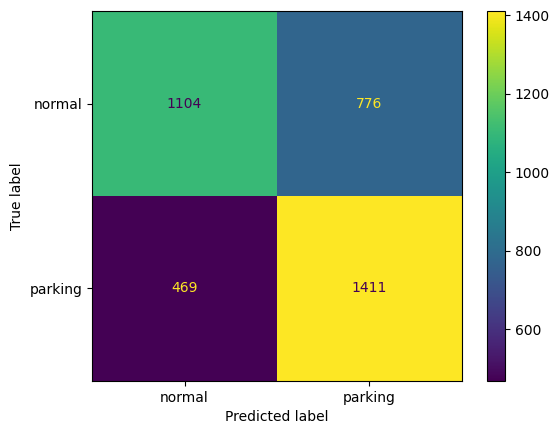

In [208]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_auc_score


def get_evaluation_results(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cfm = confusion_matrix(y_test, y_pred)
    model_name = model.best_estimator_.__class__.__name__
    print(f"Results for:\t{model_name}\n")
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"ROC AUC:\t{roc_auc}\n")
    cr = classification_report(y_test, y_pred, digits=4, target_names=labels)
    print(cr)
    cfm_display = ConfusionMatrixDisplay(cfm, display_labels=labels)
    cfm_display.plot();
    return cfm, cr


_ = get_evaluation_results(logr, X_test, y_test)

Results for:	RandomForestClassifier

ROC AUC:	0.6002659574468086

              precision    recall  f1-score   support

      normal     0.5992    0.6059    0.6025      1880
     parking     0.6014    0.5947    0.5980      1880

    accuracy                         0.6003      3760
   macro avg     0.6003    0.6003    0.6003      3760
weighted avg     0.6003    0.6003    0.6003      3760



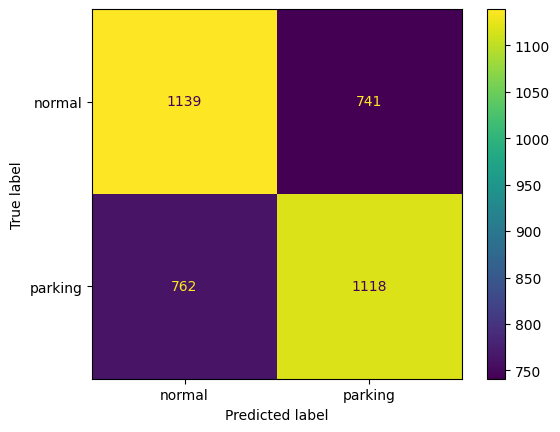

In [209]:
_ = get_evaluation_results(rf, X_test, y_test)

Results for:	SVC

ROC AUC:	0.6702127659574469

              precision    recall  f1-score   support

      normal     0.6711    0.6676    0.6693      1880
     parking     0.6693    0.6729    0.6711      1880

    accuracy                         0.6702      3760
   macro avg     0.6702    0.6702    0.6702      3760
weighted avg     0.6702    0.6702    0.6702      3760



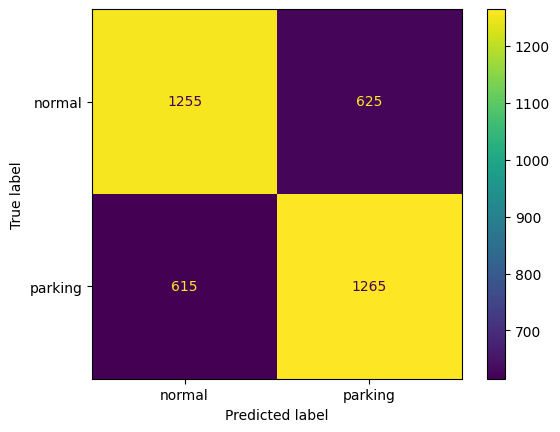

In [210]:
_ = get_evaluation_results(svc, X_test, y_test)

Results for:	XGBClassifier

ROC AUC:	0.6795212765957446

              precision    recall  f1-score   support

      normal     0.6783    0.6830    0.6806      1880
     parking     0.6808    0.6761    0.6784      1880

    accuracy                         0.6795      3760
   macro avg     0.6795    0.6795    0.6795      3760
weighted avg     0.6795    0.6795    0.6795      3760



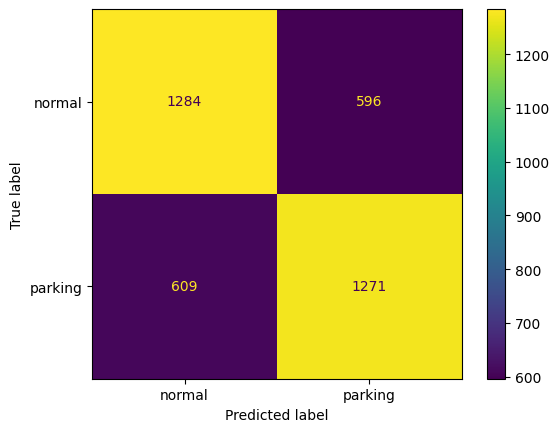

In [211]:
_ = get_evaluation_results(xg, X_test, y_test)

Based on the results above, we see that `XGBoost` performs the best on the test split. We will use this model for our real-time prediction experiment.

## Experiment 2: Prediction on user collected data

Additional real worl data was collected via a GPS logging mobile application. The data is sampled at 1 second intervals, so we must resample the data to align with the sampling interval of the taxi dataset.

In [241]:
from sklearn.metrics import classification_report

current_interval = 60
test_data_files = ["data/test/trip1.csv", "data/test/trip2.csv", "data/test/trip3.csv"]
resample_num = current_interval // interval
models = [logr, rf, svc, xg]

for test_file in test_data_files:
    print(f"\nResults for file: '{test_file}'")
    data = pd.read_csv(test_file)
    lats, longs = data["latitude"].values, data["longitude"].values
    data = list(zip(lats, longs))[-60:]
    length = LineString(data).length

    for model in models:
        model_name = model.best_estimator_.__class__.__name__
        pred = model.predict([[length]])[0]
        print(f"{model_name} prediction: '{labels[pred].upper()}'")




Results for file: 'data/test/trip1.csv'
LogisticRegression prediction: 'NORMAL'
RandomForestClassifier prediction: 'PARKING'
SVC prediction: 'NORMAL'
XGBClassifier prediction: 'NORMAL'

Results for file: 'data/test/trip2.csv'
LogisticRegression prediction: 'NORMAL'
RandomForestClassifier prediction: 'NORMAL'
SVC prediction: 'NORMAL'
XGBClassifier prediction: 'NORMAL'

Results for file: 'data/test/trip3.csv'
LogisticRegression prediction: 'NORMAL'
RandomForestClassifier prediction: 'PARKING'
SVC prediction: 'NORMAL'
XGBClassifier prediction: 'NORMAL'
